# Import the required Libraries

In [ ]:
# install Spotipy
# Spotify is an audio streaming and media services provider
!pip install spotipy

In [10]:
# install yellowbrick & Plotly
# Visualization libraries
!pip install yellowbrick
!pip install plotly

     |████████████████████████████████| 13.2 MB 3.3 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11429 sha256=682fc6f3d653189a04aac8e3ee2adacb8a0d114cba64b237a902813857a987dc
  Stored in directory: /Users/python/Library/Caches/pip/wheels/c4/a7/48/0a434133f6d56e878ca511c0e6c38326907c0792f67b476e56
Successfully built retrying


In [8]:
# install kneed
# This repository is an attempt to implement the kneedle algorithm, published here. Given a set of x and y values, kneed will return the knee point of the function. The knee point is the point of maximum curvature.

!pip install kneed


In [83]:
import sys
import spotipy
import yaml
import spotipy.util as util
from spotipy.oauth2 import SpotifyOAuth
from pprint import pprint
import json
import argparse
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
from yellowbrick.cluster import KElbowVisualizer
from kneed import KneeLocator
import plotly.graph_objects as go
from plotly.subplots import make_subplots
sns.set()

# Spotify API Calls

In [84]:
# Get Spotipy credentials from config
def load_config():
    stream = open('config.yaml')
    user_config = yaml.load(stream, Loader=yaml.FullLoader)
    return user_config

user_config = load_config()
print(user_config)

{'username': '9vv7158siqq2xvg5x37wqpp0d', 'client_id': 'ae8660143b114d849f6b2c07cee557b3', 'client_secret': '1e4bbe698cf84cf08d3250842218e4bc', 'redirect_uri': 'http://amorphoustech.com'}


In [85]:
# Initialize Spotify API token
token = util.prompt_for_user_token(user_config['username'], scope='playlist-read-private', client_id=user_config['client_id'], client_secret=user_config['client_secret'], redirect_uri=user_config['redirect_uri'])
sp = spotipy.Spotify(auth=token)


In [86]:
# A function to extract track names and URIs from a playlist
def get_playlist_info(username, playlist_uri):
    # initialize vars
    offset = 0
    tracks, uris, names, artists = [], [], [], []

    # get playlist id and name from URI
    playlist_id = playlist_uri.split(':')[2]
    playlist_name = sp.user_playlist(username, playlist_id)['name']

    # get all tracks in given playlist (max limit is 100 at a time --> use offset)
    while True:
        results = sp.user_playlist_tracks(username, playlist_id, offset=offset)
        tracks += results['items']
        if results['next'] is not None:
            offset += 100
        else:
            break
        
    # get track metadata
    for track in tracks:
        names.append(track['track']['name'])
        artists.append(track['track']['artists'][0]['name'])
        uris.append(track['track']['uri'])
    
    return playlist_name, names, artists, uris

In [87]:
# Extract features from each track in a playlist
def get_features_for_playlist(df, username, uri):
  
    # get all track metadata from given playlist
    playlist_name, names, artists, uris = get_playlist_info(username, uri)
    
    # iterate through each track to get audio features and save data into dataframe
    for name, artist, track_uri in zip(names, artists, uris):
        # print(json.dumps(track_uri, indent=4))              
        # ^ DEBUG STATEMENT ^
        
        # access audio features for given track URI via spotipy 
        audio_features = sp.audio_features(track_uri)

        # get relevant audio features
        feature_subset = [audio_features[0][col] for col in df.columns if col not in ["name", "artist", "track_URI", "playlist"]]

        # compose a row of the dataframe by flattening the list of audio features
        row = [name, artist, track_uri, *feature_subset, playlist_name]
        df.loc[len(df.index)] = row
    return df

In [88]:
spotify_df = pd.DataFrame(columns=['name', 'artist', 'track_URI', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'playlist'])

# collecting features of 500 Greatest songs of all time by rolling stone magazine (2010 update) from spotify


In [114]:
# 500 Greatest songs of all time by rolling stone magazine (2010 update)
spotify_df = get_features_for_playlist(spotify_df, user_config['username'], 'spotify:playlist:33jXjzOGlYJcnHhARPj4LK')
spotify_df


HTTP Error for GET to https://api.spotify.com/v1/playlists/33jXjzOGlYJcnHhARPj4LK returned 401 due to The access token expired


SpotifyException: http status: 401, code:-1 - https://api.spotify.com/v1/playlists/33jXjzOGlYJcnHhARPj4LK?additional_types=track:
 The access token expired, reason: None

In [137]:
spotify_df.to_csv('Spotify_rollingstone500.csv')

In [189]:
sp_df=pd.read_csv('Spotify_rollingstone500.csv')


# Identifying columns with misleading data

In [190]:

for column in sp_df:
    no_value=sp_df[column].eq(0).sum()
    if no_value>0:
        print(f'{no_value}   number of value 0 in column {column}')   

1   number of value 0 in column Unnamed: 0
163   number of value 0 in column instrumentalness


In [191]:
# Drop unname and instrumentalness columns
sp_df.drop(sp_df.columns[0], axis=1,inplace=True)
sp_df.drop(columns=['instrumentalness'],inplace=True)
sp_df.shape

(524, 12)

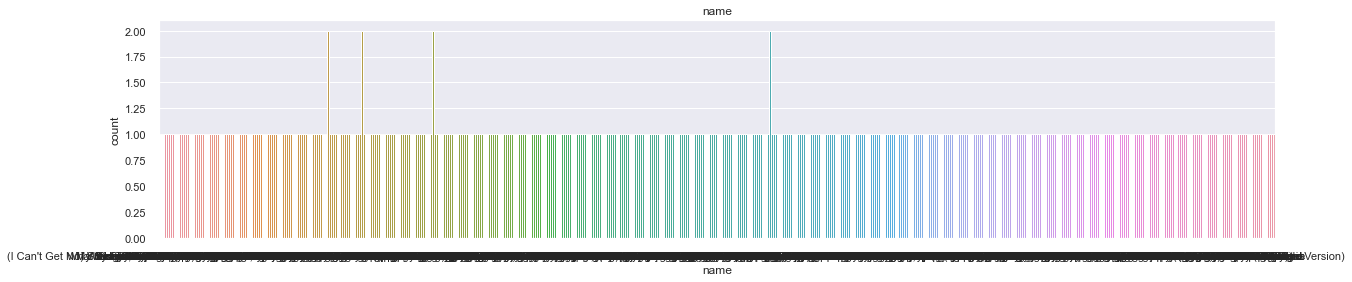

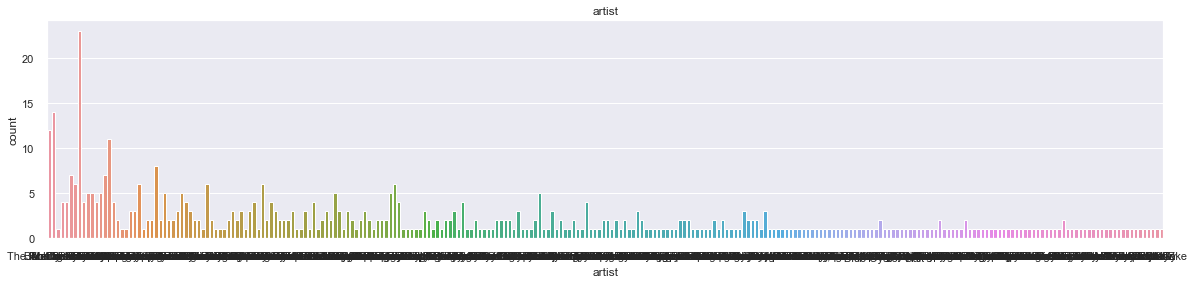

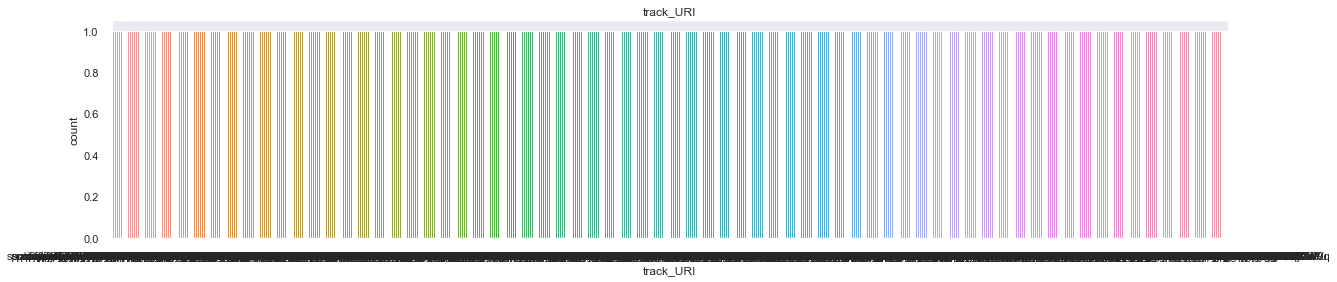

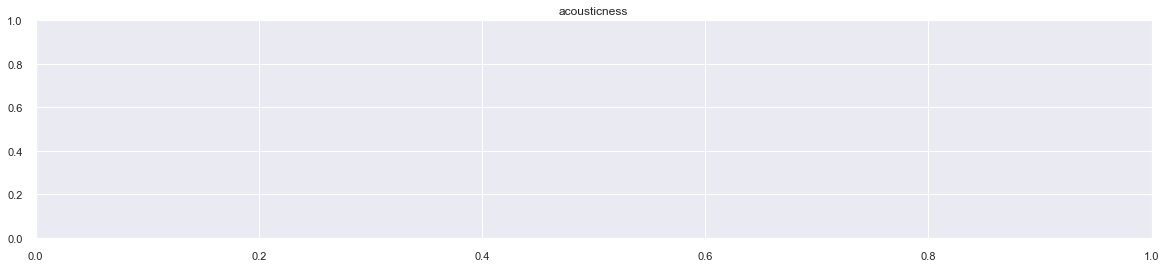

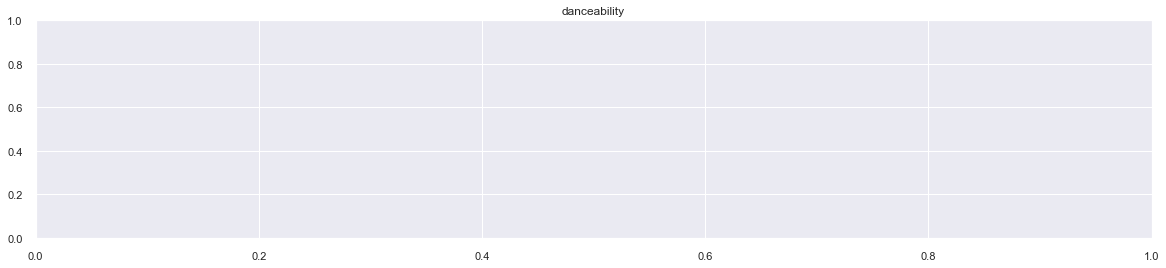

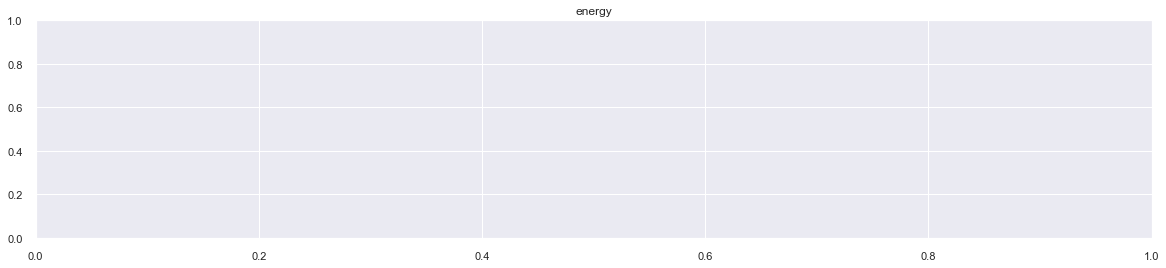

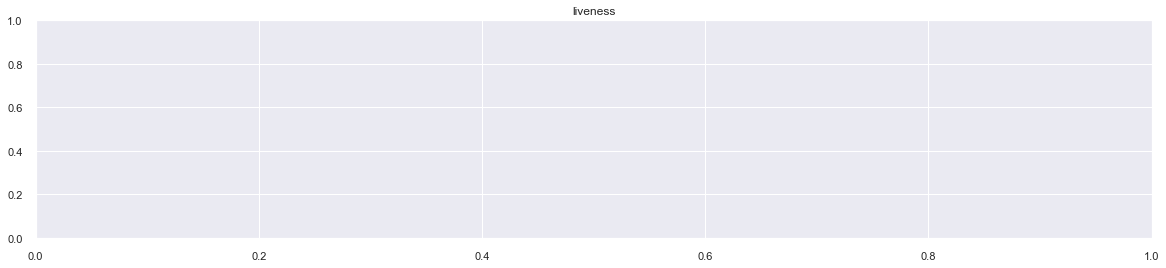

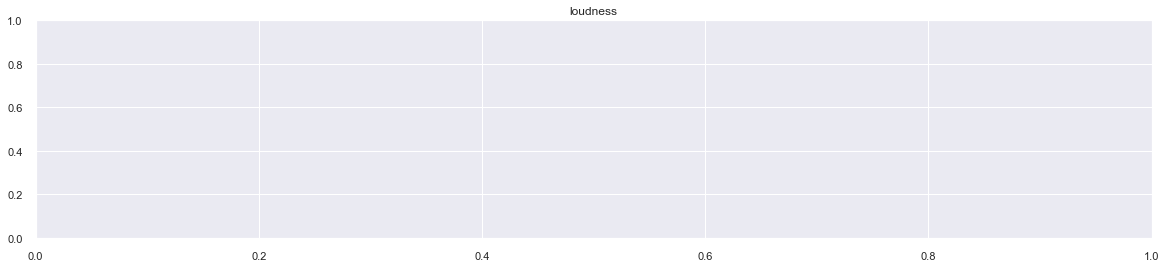

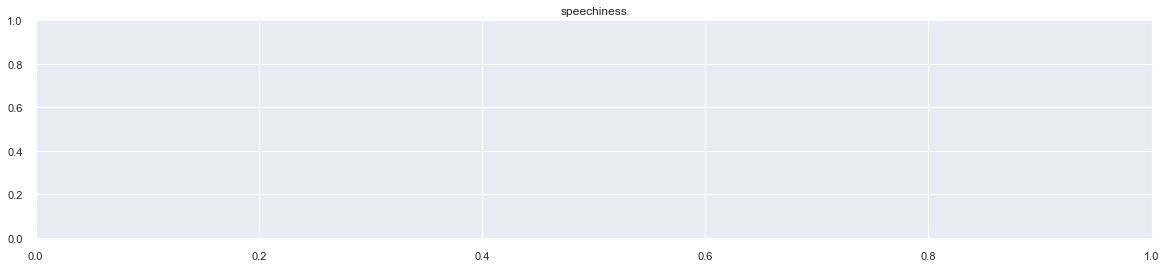

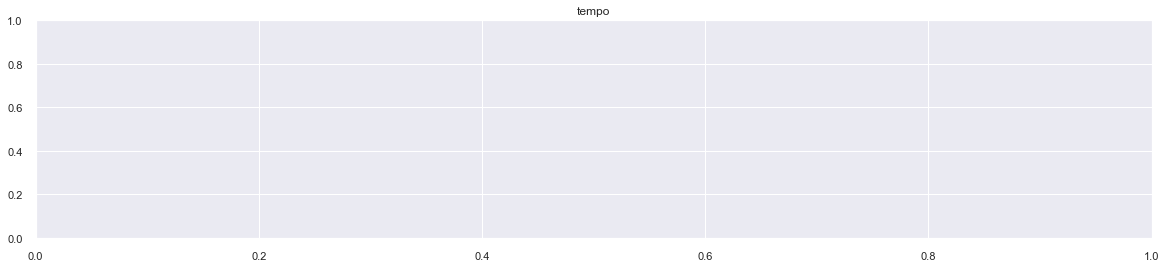

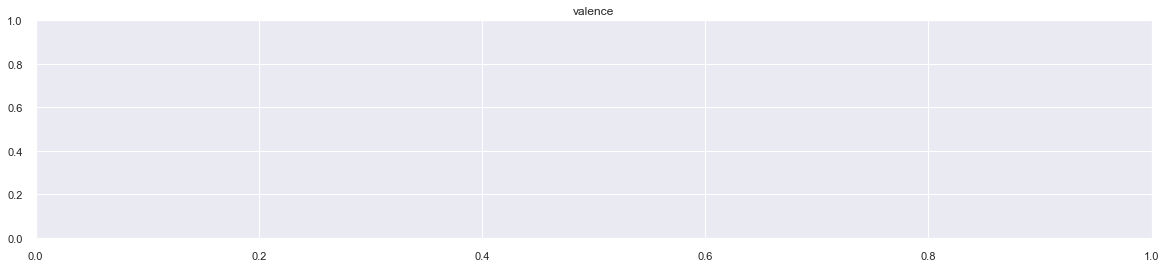

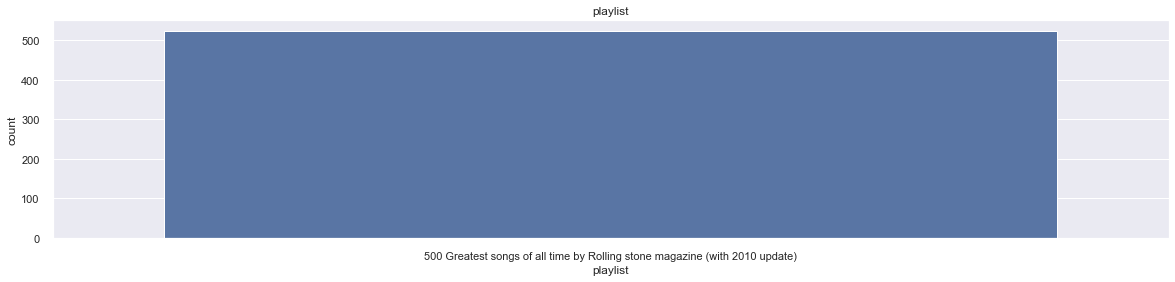

In [197]:
i=0
for column in sp_df:
    i=i+1

    plt.figure(column,figsize=(20,4))
    plt.title(column)
    #if pd.api.types.is_numeric_dtype(sp_df[column]):
    #    sns.histplot(data=sp_df, x=column,bins=50)
        
    if pd.api.types.is_string_dtype(sp_df[column]):
        fig=sns.countplot(x=column,data=sp_df)
        